# <font color="lightblue">Network Analysis</font>

In [3]:
import networkx as nx
import pandas as pd
from fa2 import ForceAtlas2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### <font color="lightblue">Modelling the Network</font>

In [4]:
df_filepath = "Data/dataframe_characters_exploded.csv"
df = pd.read_csv(df_filepath)

df.rename(columns={'Unnamed: 0': 'character'}, inplace=True)

In [5]:
df

,character,Category,Links,Seasons
0,Andy Bernard,Main_Characters,Erin Hannon,"[3, 4, 5, 6, 7, 8, 9]"
1,Andy Bernard,Main_Characters,Angela Martin,"[3, 4, 5, 6, 7, 8, 9]"
2,Andy Bernard,Main_Characters,Unnamed Cousin,"[3, 4, 5, 6, 7, 8, 9]"
3,Andy Bernard,Main_Characters,Walter Bernard Jr.,"[3, 4, 5, 6, 7, 8, 9]"
4,Andy Bernard,Main_Characters,Walter Bernard Sr.,"[3, 4, 5, 6, 7, 8, 9]"
...,...,...,...,...
945,W.B. Jones,Other,Kevin Malone,[]
946,W.B. Jones,Other,Andy Bernard,[]
947,Wally Amos,Other,NaN,[]
948,Wesley Silver,Other,Robert Lipton,[9]


In [6]:
G = nx.from_pandas_edgelist(df=df, source='character', target='Links', create_using=nx.DiGraph())
G.remove_node(np.nan)

We can then use the <code>.from_pandas_edgelist()</code> function creates a directional graph with 'index' as nodes and 'Links' defining edges.

We only care about the "central network", i.e. external characters that have no relations to the main characters/plot are not relevant for our analysis. We remove them by finding the giant connected component.

In [7]:
GCC = G.subgraph(sorted(nx.weakly_connected_components(G), key=len, reverse=True)[0])
nx.readwrite.adjlist.write_adjlist(GCC,"Data/GCC.adjlist")

print(f"{len(G.nodes()) - len(GCC.nodes)} nodes removed")

74 nodes removed


In [8]:
print(f"Nodes in the network: {GCC.number_of_nodes()}")
print(f"Number of links in the network: {GCC.number_of_edges()}")

Nodes in the network: 221
Number of links in the network: 690


In [9]:
top_connected = sorted(GCC.degree, key=lambda x: x[1], reverse=True)[:1]
top_in = sorted(GCC.in_degree, key=lambda x: x[1], reverse=True)[:1]
top_out = sorted(GCC.out_degree, key=lambda x: x[1], reverse=True)[:15]

print("The top connected character in The Office is {} with {} in/out-degrees".format(top_connected[0][0], top_connected[0][1]))
print("The character most referenced in other pages in The Office is {} with {} in-degrees".format(top_in[0][0], top_in[0][1]))
print("The character with most references on its page to other characters in The Office is {} with {} out-degrees".format(top_out[0][0], top_out[0][1]))

The top connected character in The Office is Michael Scott with 74 in/out-degrees
The character most referenced in other pages in The Office is Michael Scott with 47 in-degrees
The character with most references on its page to other characters in The Office is Andy Bernard with 29 out-degrees


Text(0, 0.5, 'Count')

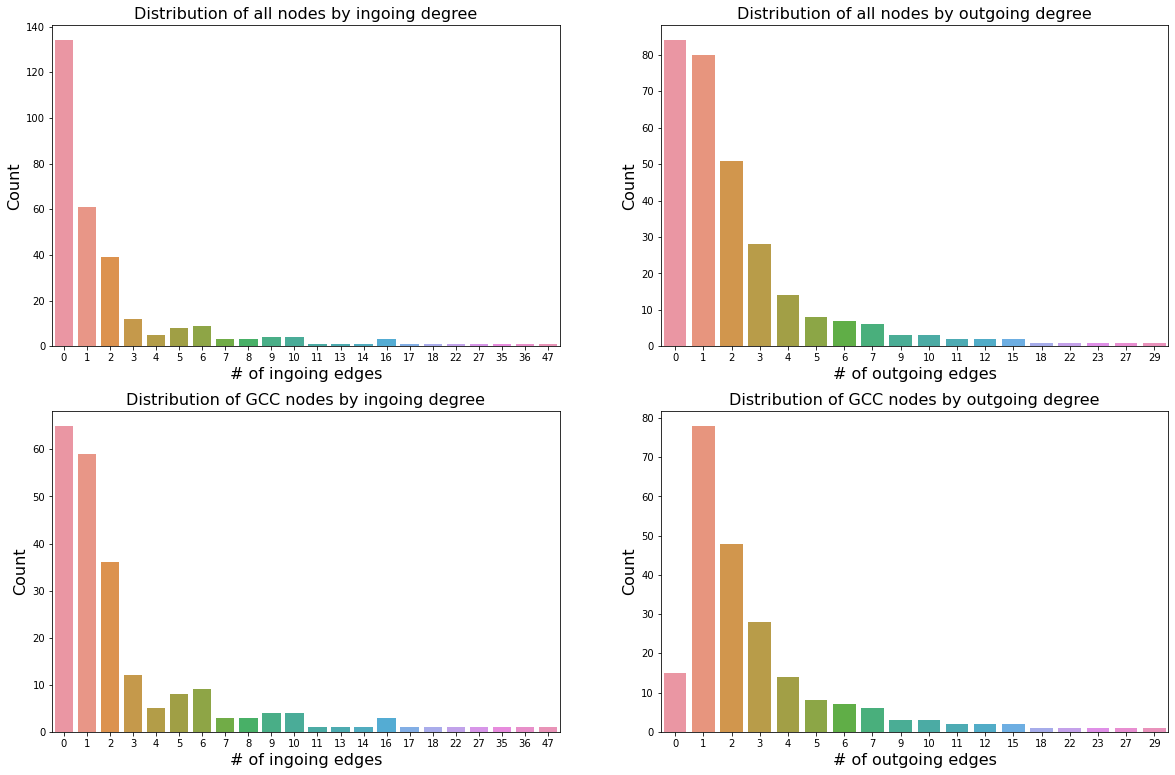

In [20]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(20,13)


sns.countplot(x = list(dict(G.in_degree).values()), ax=axs[0,0])
axs[0,0].set_title("Distribution of all nodes by ingoing degree", fontsize = 16)
axs[0,0].set_xlabel("# of ingoing edges", fontsize = 16)
axs[0,0].set_ylabel("Count", fontsize = 16)

sns.countplot(x = list(dict(G.out_degree).values()), ax=axs[0,1])
axs[0,1].set_title("Distribution of all nodes by outgoing degree", fontsize = 16)
axs[0,1].set_xlabel("# of outgoing edges",fontsize = 16)
axs[0,1].set_ylabel("Count", fontsize = 16)

sns.countplot(x = list(dict(GCC.in_degree).values()), ax=axs[1,0])
axs[1,0].set_title("Distribution of GCC nodes by ingoing degree", fontsize = 16)
axs[1,0].set_xlabel("# of ingoing edges", fontsize = 16)
axs[1,0].set_ylabel("Count", fontsize = 16)

sns.countplot(x = list(dict(GCC.out_degree).values()), ax=axs[1,1])
axs[1,1].set_title("Distribution of GCC nodes by outgoing degree", fontsize = 16)
axs[1,1].set_xlabel("# of outgoing edges", fontsize = 16)
axs[1,1].set_ylabel("Count", fontsize = 16)


### Analysis of degree distributions

**Inward degree distribution:** We see a power-law distribution, which has a large majority of nodes with few in-going links, and few instances of nodes with large in-going degrees. We can explain this by noting that the main characters overwhelmingly have many ingoing links from more minor characters, without referencing those characters in return. While interacctions with main characters are significant for minor characters, they are insignificant in the storyline of the main-characters, leading to a one-sided relationship. Similarly, the power law defines that a network usually consists of a few hubs that most other nodes are connected to. The magnitude of nodes with 0 ingoing edges is reduced after discarding all nodes not in the GCC. However, we will observe many nodes with no ingoing edges.

**Outward degree distribution:** We here see a somewhat Poisson-like distribution. However, we notice some cases where some characters have no outgoing connections. These characters were not removed when creating the GCC as they must still have an ingoing-link connecting them to the giant component. More specifically, they are referenced by a more "central" character, without them referencing that character in return. This means that the vast majority of characters that are in the GCC have just one ingoing-link.


In [9]:
# We convert to an undirected network
undirected_G = GCC.to_undirected()

# We remove self-loops 
undirected_G.remove_edges_from(nx.selfloop_edges(undirected_G))

undirected_G.remove_node("Mentioned characters")

In [10]:
characters = list(df['character'])
categories = list(df['Category'])
characters_categories_dict = dict(zip(characters, categories))

nx.set_node_attributes(GCC, characters_categories_dict, "Category")
nx.set_node_attributes(undirected_G, characters_categories_dict, "Category")

In [11]:
print([(x,y) for x,y in GCC.nodes(data=True)][:5])

[('Andy Bernard', {'Category': 'Main_Characters'}), ('Erin Hannon', {'Category': 'Main_Characters'}), ('Angela Martin', {'Category': 'Main_Characters'}), ('Unnamed Cousin', {'Category': 'Other'}), ('Walter Bernard Jr.', {'Category': 'Family_members'})]


In [57]:
# We define a color map for the roles
color_map = {'Main_Characters':'royalblue', 'Warehouse_worker':'grey', 'Former_employees':'purple', 'Family_members':'red', "Other":'grey', "Dunder_Mifflin_employees":"forestgreen", "Animals":"grey", "Characters_of_Michael_Scott":"grey", "Threat_Level_Midnight_Characters":"grey", "Characters_of_Dwight_Schrute":"grey", "The_3rd_Floor_Characters":"grey", "Unseen_Characters":"grey", "Unnamed":"grey"}

In [58]:
colors = [color_map[undirected_G.nodes(data=True)[node]['Category']] for node in undirected_G.nodes()]

In [59]:
# We label the top 10 most connected characters
topTenConnected = list(dict(sorted(undirected_G.degree, key=lambda x: x[1], reverse=True)[:10]).keys())
labels = {}
for node in undirected_G.nodes():
    if node in topTenConnected:
        labels[node] = node

As many characters fall into multiple categories, the categories were ordered by importance Main characters > Former employees > Family  > Dunder Mifflin employees.

Thus, a main character who is also a Dunder Mifflin employee will fall under the category of main character.

100%|██████████| 1000/1000 [00:01<00:00, 804.92it/s]


BarnesHut Approximation  took  0.39  seconds
Repulsion forces  took  0.70  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


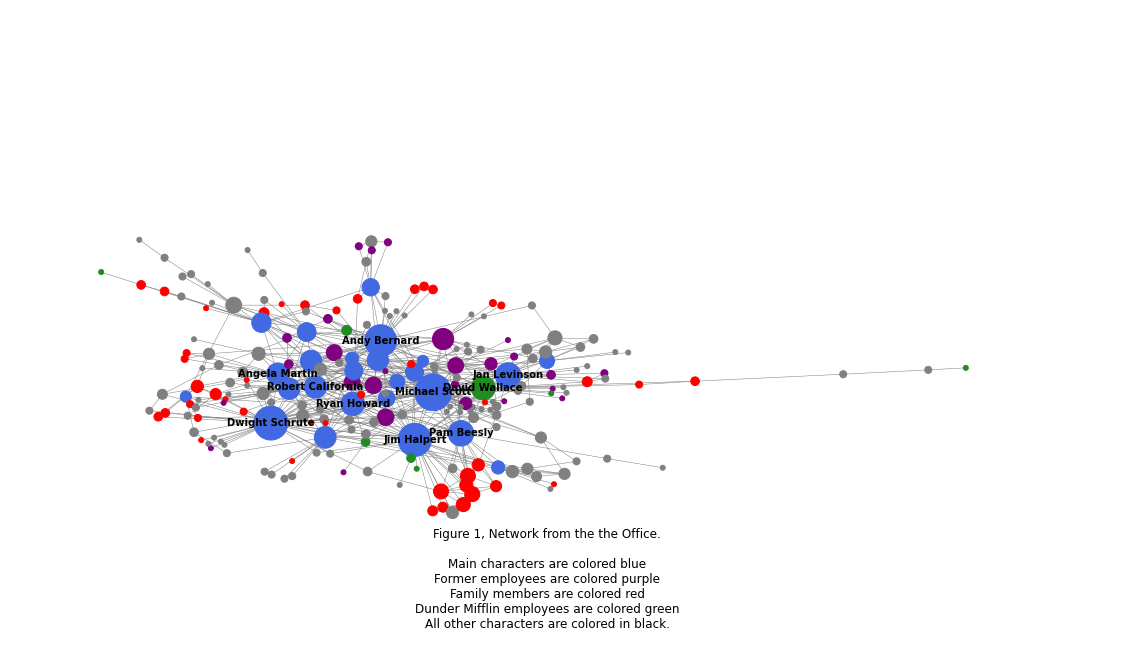

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
fig.patch.set_facecolor('white')
d = dict(undirected_G.degree)

positions = ForceAtlas2().forceatlas2_networkx_layout(undirected_G, pos=None, iterations=1000)

nx.draw_networkx_nodes(
    undirected_G,
    positions,
    nodelist=list(d.keys()),
    node_size=[v*25 for v in d.values()],
    node_color=colors)

nx.draw_networkx_edges(
    undirected_G,
    positions,
    width=0.5,
    edge_color='grey'
    )

nx.draw_networkx_labels(undirected_G, positions, labels, font_size=10, font_color="black", font_weight="bold")

#This needs to be off, for the caption to be within the figure
plt.axis('off')
caption = '''
Figure 1, Network from the the Office.

Main characters are colored blue
Former employees are colored purple
Family members are colored red
Dunder Mifflin employees are colored green
All other characters are colored in black.
'''
plt.figtext(0.5, 0, caption, wrap=True, horizontalalignment='center', fontsize=12, color="black")
plt.show()

# nx.draw_networkx(undirected_G, positions, labels, nodelist=list(d.keys()), node_size=[v*5 for v in d.values()], node_color = colors, with_labels=False, edge_color='grey')
